In [1]:
import sys
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import *
from sklearn.svm import SVR
from score_metrics import rmse, spearman, mcc, multiclass_mcc

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [2]:
def get_features_df(activities_file, compound_ft_file, target_ft_file=None):
    activities = pd.read_csv(activities_file, sep=',')
    compounds = pd.read_csv(compound_ft_file, sep=',')
    activities = activities[activities["type"] == "IC50"]
    activities = activities[["target_chembl_id",
                             "molecule_chembl_id", "standard_value"]].dropna()
    features = activities.merge(compounds, on="molecule_chembl_id")
    features["standard_value"] = features["standard_value"]/1000

    if target_ft_file:
        targets = pd.read_csv(target_ft_file, sep=',', header=None)
        targets.columns = ["target_chembl_id"] + \
            [f"prot_ft_{i}" for i in range(targets.shape[1]-1)]
        features = features[features["target_chembl_id"].isin(
            targets["target_chembl_id"])]
        features = features.merge(targets, on="target_chembl_id")

    features.to_csv("features.csv", index=False)
    return features

In [3]:
def get_docking_features_df(docking_file, compound_ft_file, target_ft_file):
    docking = pd.read_csv(docking_file, sep=',')
    compounds = pd.read_csv(compound_ft_file, sep=',')
    docking["target_chembl_id"] = "CHEMBL4523582"
    docking = docking[["target_chembl_id", "chembl_id", "docking score"]].dropna()
    docking.rename({"chembl_id":"molecule_chembl_id"}, axis=1, inplace=True)
    features = docking.merge(compounds, on="molecule_chembl_id")

    targets = pd.read_csv(target_ft_file, sep=',', header=None)
    targets.columns = ["target_chembl_id"] + \
        [f"prot_ft_{i}" for i in range(targets.shape[1]-1)]
    features = features[features["target_chembl_id"].isin(
        targets["target_chembl_id"])]
    features = features.merge(targets, on="target_chembl_id")

    features.to_csv("features_docking.csv", index=False)
    return features

In [4]:
def SVR_model(input, pred_value="standard_value", out_file="SVR_model_test.tsv"):
    input = input.sample(frac=1, random_state=0).reset_index(drop=True)
    y = input[pred_value]
    X_train, X_test, y_train, y_test = train_test_split(input, y, test_size=0.2, random_state=0)

    if "prot_ft_0" in X_train.columns: # if we use protein features
        prot_cols = [col for col in X_train.columns if col.startswith("prot_ft")]
        scaler = MinMaxScaler()
        X_train[prot_cols] = scaler.fit_transform(X_train[prot_cols])
        X_test[prot_cols] = scaler.transform(X_test[prot_cols])

    # find best parameters
    param_grid = {'C': [10, 1000, 5000, 10000, 50000], 'gamma': [0.01, 0.05, 0.1, 0.5, 1]}
    gs = GridSearchCV(SVR(), param_grid, cv=10, n_jobs=1, scoring='neg_root_mean_squared_error', verbose=3)
    gs.fit(X_train.iloc[:, 3:], y_train)
    print("Grid Search")
    print("best params: ", gs.best_params_)
    print(pd.concat([pd.DataFrame(gs.cv_results_["params"]), pd.DataFrame(-gs.cv_results_["mean_test_score"], columns=["RMSE"])],axis=1))

    # test
    model = SVR(C=gs.best_params_['C'], gamma=gs.best_params_['gamma'])
    model.fit(X_train.iloc[:, 3:], y_train)
    pred = model.predict(X_test.iloc[:, 3:])
    test_result = X_test.iloc[:, :3]
    test_result['predicted'] = pred
    test_result.to_csv(out_file, sep="\t", index=False)
    print("Test set results:")
    print(f"RMSE: {rmse(pred, y_test)}, Spearman: {spearman(pred, y_test)}, MCC: {mcc(pred, y_test.to_numpy(), np.median(y_test))}")
    return model


In [10]:
def RF_model(input, pred_value="standard_value", out_file="RF_model_test.tsv"):
    input = input.sample(frac=1, random_state=0).reset_index(drop=True)
    y = input[pred_value]
    X_train, X_test, y_train, y_test = train_test_split(input, y, test_size=0.2, random_state=0)

    if "prot_ft_0" in X_train.columns: # if we use protein features
        prot_cols = [col for col in X_train.columns if col.startswith("prot_ft")]
        scaler = MinMaxScaler()
        X_train[prot_cols] = scaler.fit_transform(X_train[prot_cols])
        X_test[prot_cols] = scaler.transform(X_test[prot_cols])

    # find best parameters
    param_grid = {'n_estimators': [10, 50, 100, 500], 'max_features': ['sqrt', 'log2'], 'max_depth': [10, 20, 50, 100]}
    gs = GridSearchCV(RandomForestRegressor(), param_grid, cv=10, n_jobs=1, scoring='neg_root_mean_squared_error', verbose=3)
    gs.fit(X_train.iloc[:, 3:], y_train)
    print("Grid Search")
    print("best params: ", gs.best_params_)
    print(pd.concat([pd.DataFrame(gs.cv_results_["params"]), pd.DataFrame(-gs.cv_results_["mean_test_score"], columns=["RMSE"])],axis=1))

    # test
    model = RandomForestRegressor(n_estimators=gs.best_params_['n_estimators'], max_features=gs.best_params_['max_features'], max_depth=gs.best_params_['max_depth'])
    model.fit(X_train.iloc[:, 3:], y_train)
    pred = model.predict(X_test.iloc[:, 3:])
    test_result = X_test.iloc[:, :3]
    test_result['predicted'] = pred
    test_result.to_csv(out_file, sep="\t", index=False)
    print("Test set results:")
    print(f"RMSE: {rmse(pred, y_test)}, Spearman: {spearman(pred, y_test)}, MCC: {mcc(pred, y_test.to_numpy(), np.median(y_test))}")
    return model


In [8]:
activities_file = "activities.csv"
compound_ft_file = "ligands_ecfp4.csv"
target_ft_file = "targets_embedding.csv"

input = get_features_df(activities_file, compound_ft_file, target_ft_file)
svr = SVR_model(input)


Grid Search
best params:  {'C': 10000, 'gamma': 0.05}
           C  gamma       RMSE
0        0.1  0.001  30.293021
1        0.1  0.005  29.938034
2        0.1  0.010  29.970752
3        0.1  0.050  30.430278
4        0.1  0.100  30.523872
5        0.1  0.500  30.579028
6        0.1  1.000  30.580412
7       10.0  0.001  27.556163
8       10.0  0.005  26.310064
9       10.0  0.010  25.263038
10      10.0  0.050  23.655354
11      10.0  0.100  24.527894
12      10.0  0.500  26.059362
13      10.0  1.000  26.123304
14    1000.0  0.001  20.878570
15    1000.0  0.005  17.527031
16    1000.0  0.010  17.942156
17    1000.0  0.050  17.417289
18    1000.0  0.100  17.426527
19    1000.0  0.500  20.013791
20    1000.0  1.000  21.177231
21    5000.0  0.001  17.912419
22    5000.0  0.005  18.023761
23    5000.0  0.010  17.904481
24    5000.0  0.050  17.417289
25    5000.0  0.100  17.426527
26    5000.0  0.500  20.013791
27    5000.0  1.000  21.177231
28   10000.0  0.001  18.009704
29   10000.0  0.

In [ ]:
rf = RF_model(input)


Fitting 20 folds for each of 100 candidates, totalling 2000 fits
Grid Search
best params:  {'bootstrap': False, 'max_depth': 50, 'max_features': 'sqrt', 'n_estimators': 10}
    bootstrap  max_depth max_features  n_estimators       RMSE
0       False          5         sqrt            10  23.386535
1       False          5         sqrt            50  22.042334
2       False          5         sqrt           100  22.302992
3       False          5         sqrt           500  22.048880
4       False          5         sqrt          1000  22.078448
..        ...        ...          ...           ...        ...
95       True        100         log2            10  19.622996
96       True        100         log2            50  18.887482
97       True        100         log2           100  18.723559
98       True        100         log2           500  18.624244
99       True        100         log2          1000  18.707181

[100 rows x 5 columns]
Test set results:
RMSE: 14.14955726412044, Spea

In [5]:
docking_file = "7rdx_ADP_docking.csv"
compound_ft_file = "ligands_ecfp4.csv"
target_ft_file = "targets_embedding.csv"

input = get_docking_features_df(docking_file, compound_ft_file, target_ft_file)
svr = SVR_model(input, pred_value="docking score", out_file="SVR_docking_model_test.tsv")


[CV 5/10] END .............C=50000, gamma=0.01;, score=-1.066 total time=   3.6s
[CV 6/10] END .............C=50000, gamma=0.01;, score=-1.107 total time=   4.0s
[CV 7/10] END .............C=50000, gamma=0.01;, score=-1.092 total time=   3.7s
[CV 8/10] END .............C=50000, gamma=0.01;, score=-0.966 total time=   4.0s
[CV 9/10] END .............C=50000, gamma=0.01;, score=-1.012 total time=   4.0s
[CV 10/10] END ............C=50000, gamma=0.01;, score=-1.025 total time=   3.9s
[CV 1/10] END .............C=50000, gamma=0.05;, score=-1.048 total time=   3.6s
[CV 2/10] END .............C=50000, gamma=0.05;, score=-1.066 total time=   3.7s
[CV 3/10] END .............C=50000, gamma=0.05;, score=-1.036 total time=   3.7s
[CV 4/10] END .............C=50000, gamma=0.05;, score=-1.102 total time=   3.7s
[CV 5/10] END .............C=50000, gamma=0.05;, score=-1.057 total time=   3.6s
[CV 6/10] END .............C=50000, gamma=0.05;, score=-1.076 total time=   3.8s
[CV 7/10] END .............C

In [11]:
rf = RF_model(input, pred_value="docking score", out_file="RF_docking_model_test.tsv")


Fitting 10 folds for each of 32 candidates, totalling 320 fits
[CV 1/10] END max_depth=10, max_features=sqrt, n_estimators=10;, score=-1.064 total time=   0.2s
[CV 2/10] END max_depth=10, max_features=sqrt, n_estimators=10;, score=-1.045 total time=   0.2s
[CV 3/10] END max_depth=10, max_features=sqrt, n_estimators=10;, score=-1.028 total time=   0.2s
[CV 4/10] END max_depth=10, max_features=sqrt, n_estimators=10;, score=-0.970 total time=   0.2s
[CV 5/10] END max_depth=10, max_features=sqrt, n_estimators=10;, score=-0.951 total time=   0.2s
[CV 6/10] END max_depth=10, max_features=sqrt, n_estimators=10;, score=-0.897 total time=   0.2s
[CV 7/10] END max_depth=10, max_features=sqrt, n_estimators=10;, score=-0.975 total time=   0.1s
[CV 8/10] END max_depth=10, max_features=sqrt, n_estimators=10;, score=-0.898 total time=   0.2s
[CV 9/10] END max_depth=10, max_features=sqrt, n_estimators=10;, score=-0.929 total time=   0.2s
[CV 10/10] END max_depth=10, max_features=sqrt, n_estimators=10;

In [43]:
svr_ic50 = SVR(C=10000, gamma=0.05)
svr_docking = SVR(C=10, gamma=0.01)
rf_ic50 = RandomForestRegressor(max_depth=50, max_features='sqrt', n_estimators=10)
rf_docking = RandomForestRegressor(max_depth=20, max_features='sqrt', n_estimators=500)

in_ic50 = pd.read_csv('features.csv').sample(frac=1, random_state=0).reset_index(drop=True)
in_docking = pd.read_csv('features_docking.csv').sample(frac=1, random_state=0).reset_index(drop=True)

y = in_ic50['standard_value']
X_train, X_test, y_train_ic50, y_test_ic50 = train_test_split(in_ic50, y, test_size=0.2, random_state=0)
svr_ic50.fit(X_train.iloc[:, 3:], y_train_ic50)
rf_ic50.fit(X_train.iloc[:, 3:], y_train_ic50)
svr_ic50_pred = svr_ic50.predict(X_test.iloc[:, 3:])
rf_ic50_pred = rf_ic50.predict(X_test.iloc[:, 3:])
svr_ic50_errors = abs(svr_ic50_pred-y_test_ic50)
rf_ic50_errors = abs(rf_ic50_pred-y_test_ic50)

y = in_docking['docking score']
X_train, X_test, y_train_docking, y_test_docking = train_test_split(in_docking, y, test_size=0.2, random_state=0)
svr_docking.fit(X_train.iloc[:, 3:], y_train_docking)
rf_docking.fit(X_train.iloc[:, 3:], y_train_docking)
svr_docking_pred = svr_docking.predict(X_test.iloc[:, 3:])
rf_docking_pred = rf_docking.predict(X_test.iloc[:, 3:])
svr_docking_errors = abs(svr_docking_pred-y_test_docking)
rf_docking_errors = abs(rf_docking_pred-y_test_docking)

Text(0.5, 0, 'docking score error')

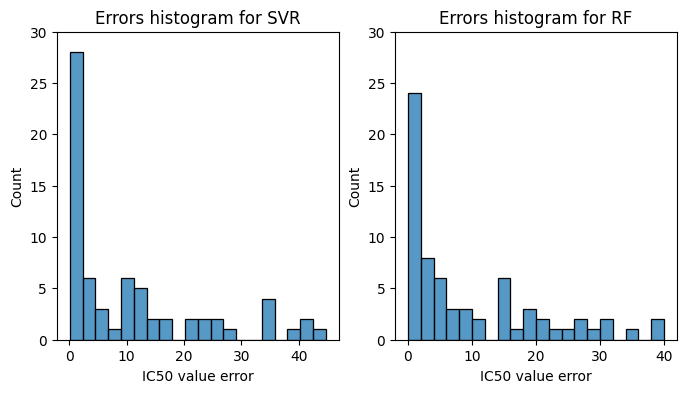

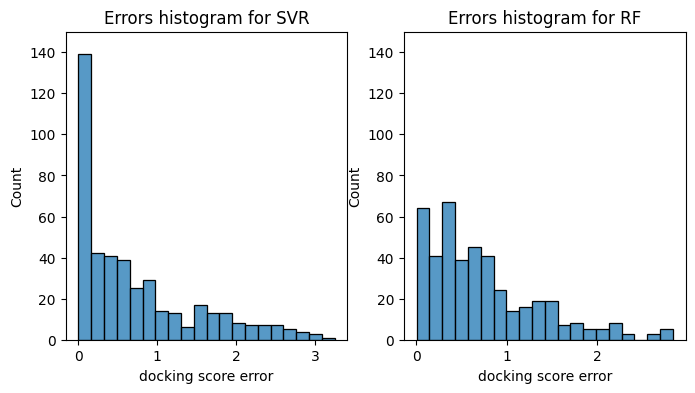

In [44]:
import seaborn as sns
from matplotlib import pyplot as plt

fig, axes = plt.subplots(1,2,figsize=(8,4))
sns.histplot(svr_ic50_errors, bins=20, ax=axes[0])
sns.histplot(rf_ic50_errors, bins=20, ax=axes[1])
axes[0].set_ylim(0,30)
axes[0].set_xlabel("IC50 value error")
axes[0].set_title("Errors histogram for SVR")
axes[1].set_ylim(0,30)
axes[1].set_title("Errors histogram for RF")
axes[1].set_xlabel("IC50 value error")

fig, axes = plt.subplots(1,2,figsize=(8,4))
sns.histplot(svr_docking_errors, bins=20, ax=axes[0])
sns.histplot(rf_docking_errors, bins=20, ax=axes[1])
axes[0].set_ylim(0,150)
axes[0].set_xlabel("docking score error")
axes[0].set_title("Errors histogram for SVR")
axes[1].set_ylim(0,150)
axes[1].set_title("Errors histogram for RF")
axes[1].set_xlabel("docking score error")



Text(0.5, 1.0, 'RMSE for docking')

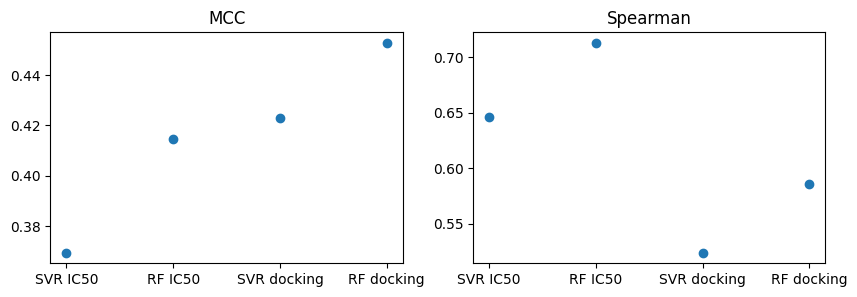

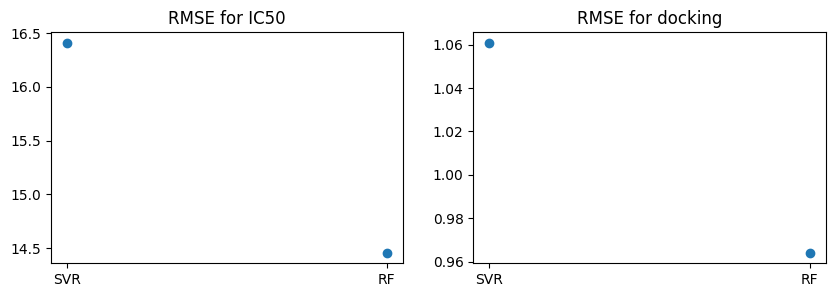

In [62]:
import score_metrics

mcc_scores = []
mcc_scores.append(score_metrics.mcc(svr_ic50_pred, y_test_ic50.to_numpy(), np.median(y_train_ic50)))
mcc_scores.append(score_metrics.mcc(rf_ic50_pred, y_test_ic50.to_numpy(), np.median(y_train_ic50)))
mcc_scores.append(score_metrics.mcc(svr_docking_pred, y_test_docking.to_numpy(), np.median(y_train_docking)))
mcc_scores.append(score_metrics.mcc(rf_docking_pred, y_test_docking.to_numpy(), np.median(y_train_docking)))

spearman_scores = []
spearman_scores.append(spearman(svr_ic50_pred, y_test_ic50))
spearman_scores.append(spearman(rf_ic50_pred, y_test_ic50))
spearman_scores.append(spearman(svr_docking_pred, y_test_docking))
spearman_scores.append(spearman(rf_docking_pred, y_test_docking))

rmse_scores = []
rmse_scores.append(rmse(svr_ic50_pred, y_test_ic50))
rmse_scores.append(rmse(rf_ic50_pred, y_test_ic50))
rmse_scores.append(rmse(svr_docking_pred, y_test_docking))
rmse_scores.append(rmse(rf_docking_pred, y_test_docking))

fig, axes = plt.subplots(1,2,figsize=(10,3))
axes[0].scatter(['SVR IC50', 'RF IC50', 'SVR docking', 'RF docking'], mcc_scores)
axes[1].scatter(['SVR IC50', 'RF IC50', 'SVR docking', 'RF docking'], spearman_scores)
axes[0].set_title("MCC")
axes[1].set_title("Spearman")

fig, axes = plt.subplots(1,2,figsize=(10,3))
axes[0].scatter(['SVR', 'RF'], rmse_scores[:2])
axes[1].scatter(['SVR', 'RF'], rmse_scores[2:])
axes[0].set_title("RMSE for IC50")
axes[1].set_title("RMSE for docking")
